In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [6]:
Train_path = "../datasets/BuzzInSocialMedia/Twitter/Twitter.data"
train_df = pd.read_csv(Train_path, header = None)

Data description says it has no missing values and no categorical columns.

In [7]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [8]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 35, dtype('float64'): 43}


In [9]:
print((train_df.iloc[:, -1]).value_counts())

0.5       20770
1.0       19299
0.0       19094
1.5       17510
2.0       15254
          ...  
3737.0        1
3667.5        1
3708.5        1
3851.0        1
2129.5        1
Name: 77, Length: 8123, dtype: int64


We have to predict whether there is a Buzz magnitude or not, i.e., whether the last column for the sample has 0 or any other value.

In [10]:
old_pred = train_df[77].to_numpy()
new_pred = []
for i in range(len(old_pred)):
    if old_pred[i] > 0.0:
        new_pred.append(1)
    else:
        new_pred.append(0)
train_df[77] = new_pred

In [11]:
train_df[77].value_counts()

1    564156
0     19094
Name: 77, dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df[77]
y_test = test_df[77]
X_train = train_df.drop([77], axis = 1)
X_test = test_df.drop([77], axis = 1)

In [13]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [14]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [15]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [16]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.965418
Error Rate: 0.03458208315473643
Mean Recall: 0.5654588478638659
Balanced Accuracy Score: 0.5654588478638659
Precision: 0.6827796899956426
F-Score: 0.593332049117205
58325 58325
Selectivity: 0.13798614810868406
G_mean: 0.27933042858004076


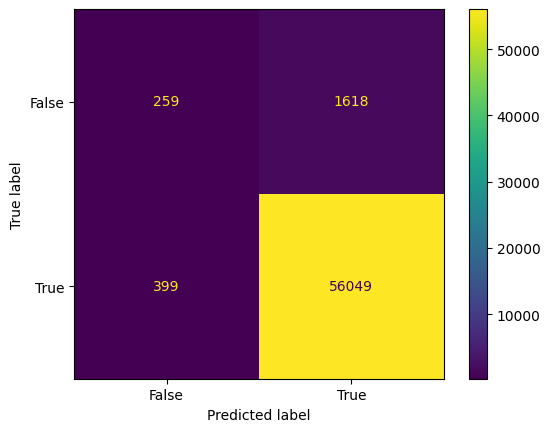

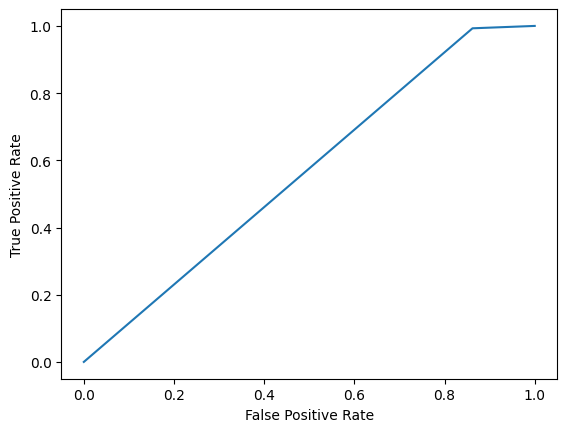

In [17]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({1: 507708, 0: 507708})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.921063
Error Rate: 0.0789369909987141
Mean Recall: 0.7076173595103998
Balanced Accuracy Score: 0.7076173595103998
Precision: 0.5903233153220164
F-Score: 0.6196565881063012
58325 58325
Selectivity: 0.47948854555141185
G_mean: 0.5824898441334168


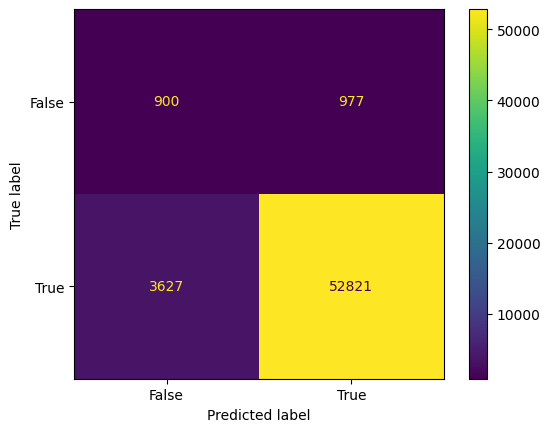

Resampled dataset shape Counter({1: 507708, 0: 507708})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.915388
Error Rate: 0.08461208744106297
Mean Recall: 0.7255449676429797
Balanced Accuracy Score: 0.7255449676429797
Precision: 0.5893046984746503
F-Score: 0.6197534535087799
58325 58325
Selectivity: 0.5226425146510388
G_mean: 0.6157926975706464


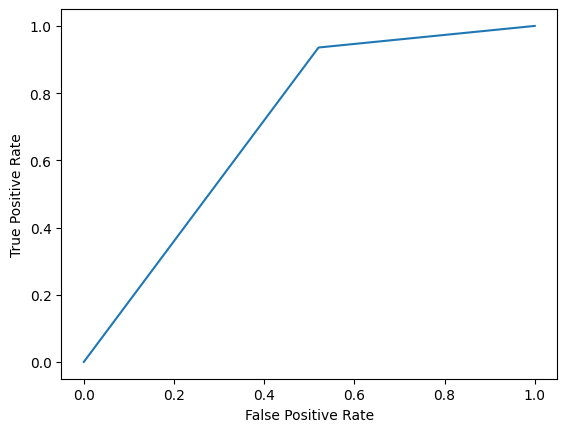

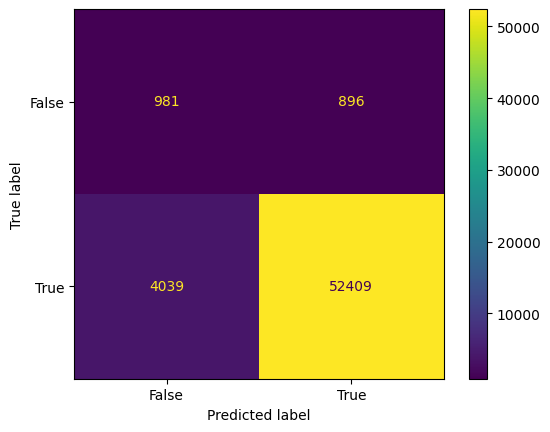

Resampled dataset shape Counter({1: 507708, 0: 507708})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.912576
Error Rate: 0.08742391770252889
Mean Recall: 0.7282127002927792
Balanced Accuracy Score: 0.7282127002927792
Precision: 0.5872864708759055
F-Score: 0.6172901252377272
58325 58325
Selectivity: 0.5311667554608418
G_mean: 0.6219343834359811


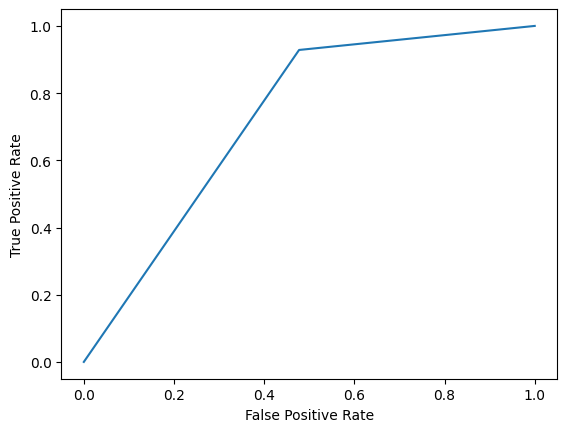

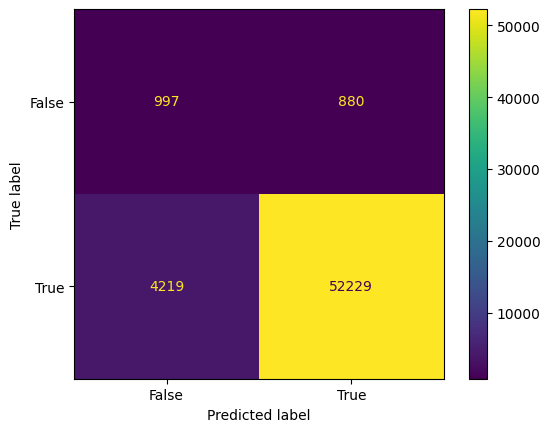

Resampled dataset shape Counter({1: 507708, 0: 507708})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.911273
Error Rate: 0.08872696099442778
Mean Recall: 0.7342351595561862
Balanced Accuracy Score: 0.7342351595561862
Precision: 0.5876553273334797
F-Score: 0.6180246600395982
58325 58325
Selectivity: 0.5450186467767715
G_mean: 0.6325913792308898


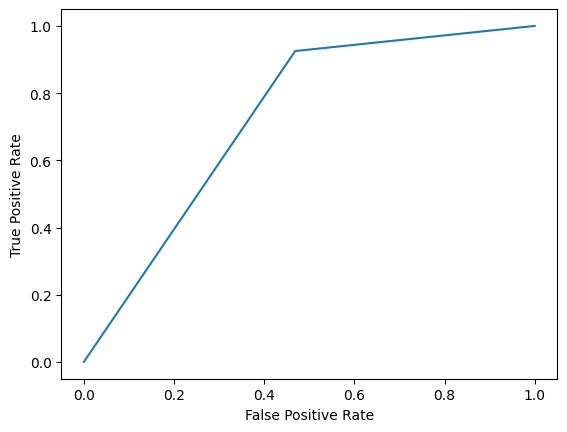

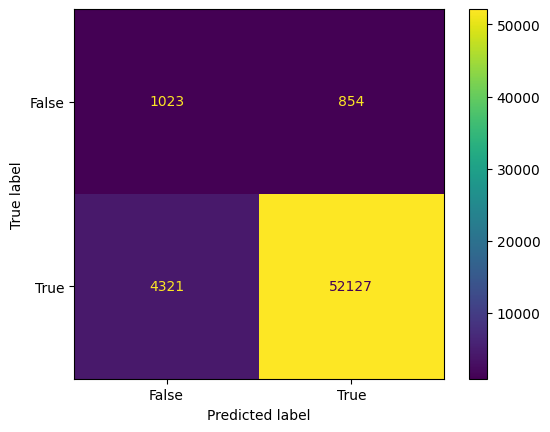

Resampled dataset shape Counter({1: 507708, 0: 507708})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.909730
Error Rate: 0.0902700385769396
Mean Recall: 0.7362707386497487
Balanced Accuracy Score: 0.7362707386497487
Precision: 0.5867855286255316
F-Score: 0.6169250679623375
58325 58325
Selectivity: 0.5508790623335109
G_mean: 0.6368642980502008


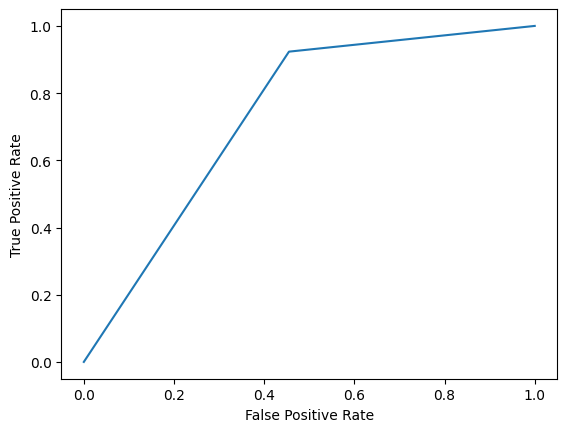

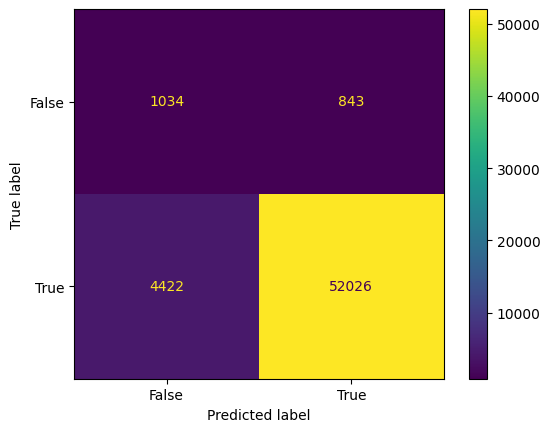

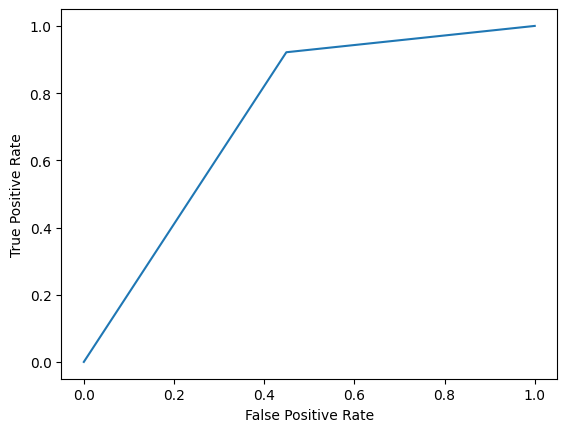

In [18]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.910947
Error Rate: 0.08905272181740254
Mean Recall: 0.737929735304262
Balanced Accuracy Score: 0.737929735304262
Precision: 0.5883105987006143
F-Score: 0.6190356273436146
58325 58325
Selectivity: 0.5530101225359616
G_mean: 0.6388134417367403


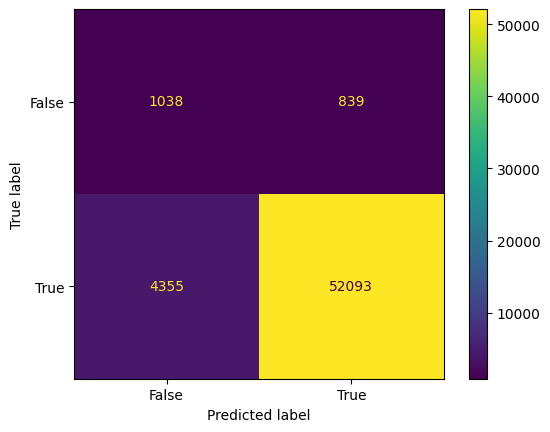

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.904123
Error Rate: 0.0958765537933991
Mean Recall: 0.7423876361057653
Balanced Accuracy Score: 0.7423876361057653
Precision: 0.5836213458320612
F-Score: 0.6126221507269539
58325 58325
Selectivity: 0.5695258391049547
G_mean: 0.6502376037990111


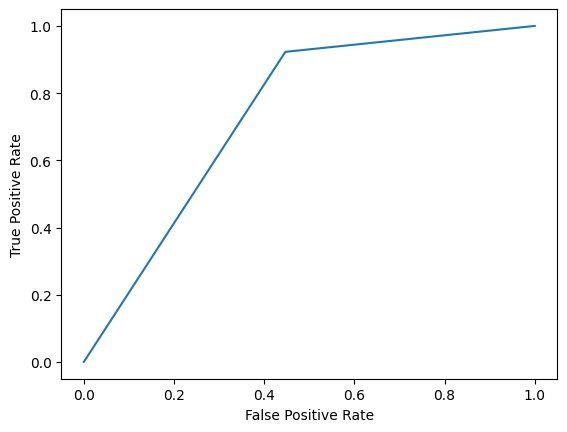

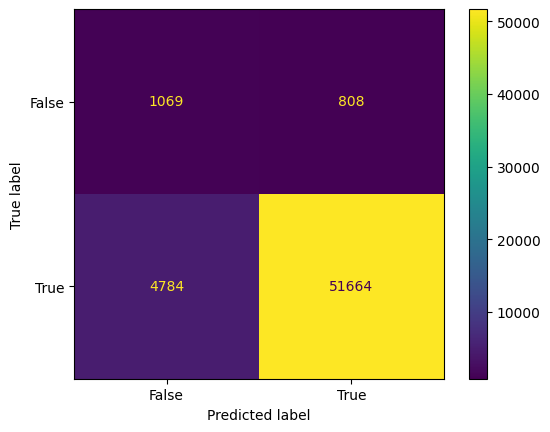

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.900832
Error Rate: 0.09916845263609086
Mean Recall: 0.7484127003003297
Balanced Accuracy Score: 0.7484127003003297
Precision: 0.5825589368484811
F-Score: 0.611071620388706
58325 58325
Selectivity: 0.5855087906233352
G_mean: 0.6619684396102209


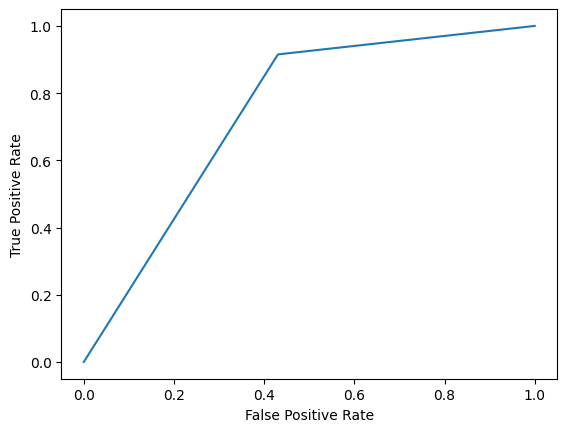

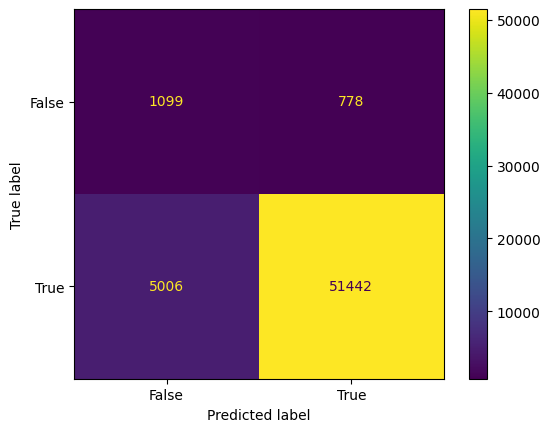

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.911873
Error Rate: 0.08812687526789542
Mean Recall: 0.7219264634352232
Balanced Accuracy Score: 0.7219264634352232
Precision: 0.5849555668007074
F-Score: 0.6139583118630008
58325 58325
Selectivity: 0.5189131592967501
G_mean: 0.6120597535544233


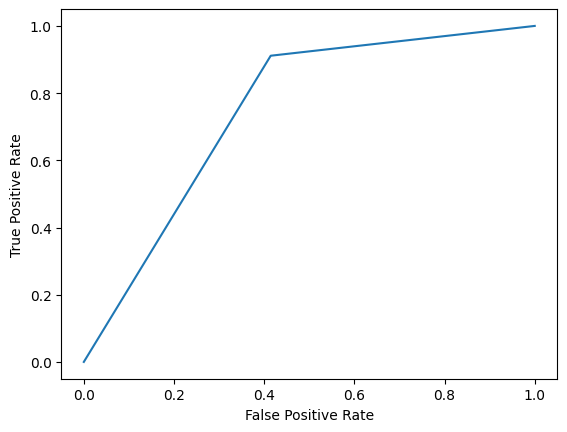

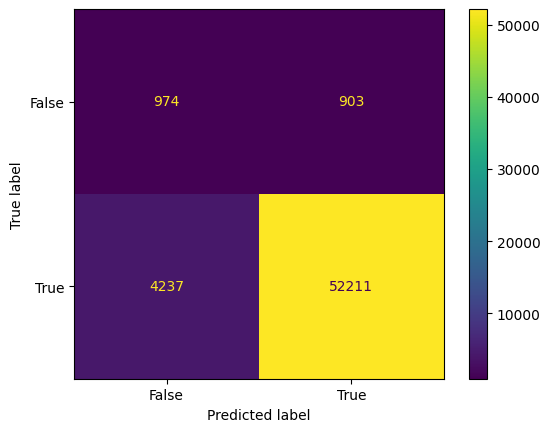

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.914822
Error Rate: 0.08517788255465064
Mean Recall: 0.7077409757634185
Balanced Accuracy Score: 0.7077409757634185
Precision: 0.5838162981222262
F-Score: 0.6117718607798163
58325 58325
Selectivity: 0.4864144912093767
G_mean: 0.586732875024053


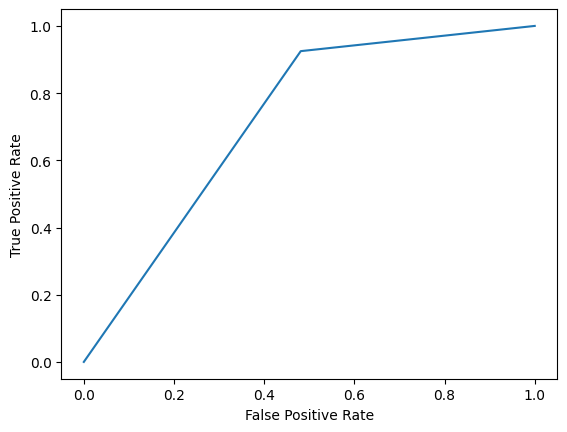

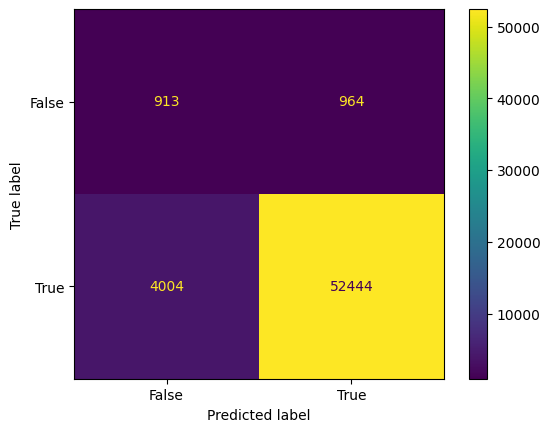

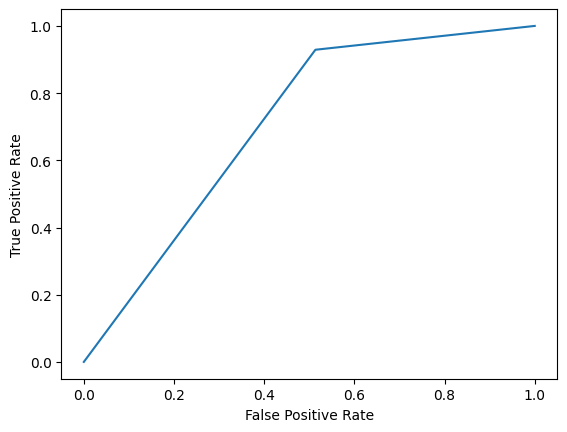

In [19]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)